In [2]:
import os
from dotenv import load_dotenv
from IPython.display import display, Image

from langchain_openai import ChatOpenAI
from langgraph.prebuilt import create_react_agent
from langchain_core.tools import tool
from langchain_core.tools.retriever import create_retriever_tool
from langgraph.checkpoint.memory import InMemorySaver

# For QA-Retriever
from langchain_core.prompts import PromptTemplate
from langchain.chains.combine_documents import create_stuff_documents_chain
from langchain.chains import create_retrieval_chain

# Custom Import
from optcg.vectorstore_logic import check_for_updates_to_rules, create_or_load_vectorstore_optcg_rulebooks
from optcg.agents import RulebookAgent

from langsmith import traceable
from langsmith.wrappers import wrap_openai
from openai import OpenAI
#openai_client = wrap_openai(OpenAI())

_ = load_dotenv() # Loads the .env file - e.g. the OPENAI_API_KEY


In [ ]:
import requests
response = requests.post(
    "http://localhost:8000/chat",
    json={
        "message": "What are the One Piece TCG rules?",
        "agent_type": "rulebook",
        "thread_id": "sample-thread-id"
    }
)
print(response.json())

In [2]:
from optcg.agents import RulebookAgent
agent = RulebookAgent()
agent.chat("hi", thread_id="user1", verbose=True)
agent.chat("repeat what I just said", thread_id="user1", verbose=True)

Loading existing vector store...


{'messages': [HumanMessage(content='hi', additional_kwargs={}, response_metadata={}, id='3cc47002-9142-489d-aa82-5395636de166'),
  AIMessage(content='Hello! How can I help you with the One Piece TCG rulebook today? If you have any questions about the rules or need clarification on a specific situation, just let me know!', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 39, 'prompt_tokens': 217, 'total_tokens': 256, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4.1-2025-04-14', 'system_fingerprint': 'fp_51e1070cf2', 'id': 'chatcmpl-BmTy04hZmXuNY2VvaElXvnRfZYDoj', 'service_tier': 'default', 'finish_reason': 'stop', 'logprobs': None}, name='BaseAgent', id='run--8a54fb02-7bce-43b4-ad96-adf09a94ea52-0', usage_metadata={'input_tokens': 217, 'output_tokens': 39, 'total_tok

In [7]:
from optcg.agents import RulebookAgent
agent = RulebookAgent()
agent.chat("hi", thread_id="yo", verbose=True)

Loading existing vector store...


{'messages': [HumanMessage(content='hi', additional_kwargs={}, response_metadata={}, id='0000b1d8-c2f8-4d02-9736-1e9f686d785f'),
  AIMessage(content='Hello! How can I help you with the One Piece TCG rulebook today? If you have any questions about the rules or need clarification on a specific situation, just let me know!', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 39, 'prompt_tokens': 217, 'total_tokens': 256, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4.1-2025-04-14', 'system_fingerprint': 'fp_799e4ca3f1', 'id': 'chatcmpl-BmvrtnedvgFZ9Yd8tjqjX16OcVaRS', 'service_tier': 'default', 'finish_reason': 'stop', 'logprobs': None}, name='BaseAgent', id='run--36b9ed1f-ffe8-4b96-98cc-e2b26c288ddd-0', usage_metadata={'input_tokens': 217, 'output_tokens': 39, 'total_tok

In [10]:
agent.chat("repeat what I just said", thread_id="yo")

'You said: "repeat what I just said"'

In [ ]:
from optcg.agents import RulebookAgent

agent = RulebookAgent()
agent.chat("What is the rule for attacking with a creature?", verbose=True)

Loading existing vector store...


{'messages': [HumanMessage(content='What is the rule for attacking with a creature?', additional_kwargs={}, response_metadata={}, id='ee2892e5-7e5e-4387-b25e-b3b1bbe99032'),
  AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_EuiK87k5hgH9x7VWOzVSSnds', 'function': {'arguments': '{"query":"rule for attacking with a creature"}', 'name': 'rulebooks_retriever'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 22, 'prompt_tokens': 226, 'total_tokens': 248, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4.1-2025-04-14', 'system_fingerprint': 'fp_51e1070cf2', 'id': 'chatcmpl-BmTc9vGXcCmDi733etauSWE0iCCad', 'service_tier': 'default', 'finish_reason': 'tool_calls', 'logprobs': None}, name='BaseAgent', id='run--1e2f599e-eb21-4dad-a79e-e27a65b5ee35-0', too

In [8]:
message = "What are the rules for the game of chess?"
thread_id = "optcg-rulebook-agent"
agent.invoke(
            {"messages": [{"role": "user", "content": message}]},
            config={"configurable": {"thread_id": thread_id}}
        )

{'messages': [HumanMessage(content='What are the rules for the game of chess?', additional_kwargs={}, response_metadata={}, id='2096d8ff-c78f-49b3-8a85-1a184488cded'),
  AIMessage(content='I’m sorry, but I can only provide information about the rules for the One Piece TCG (Trading Card Game). If you have any questions about the One Piece TCG, feel free to ask!', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 42, 'prompt_tokens': 226, 'total_tokens': 268, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4.1-2025-04-14', 'system_fingerprint': 'fp_51e1070cf2', 'id': 'chatcmpl-BmSb6cUKTQUZypBm2F8exv0Dvx5kr', 'service_tier': 'default', 'finish_reason': 'stop', 'logprobs': None}, name='BaseAgent', id='run--aafcbcd6-3e7e-4128-84af-309f981022f5-0', usage_metadata={'input_toke

Loading existing vector store...


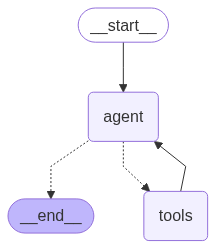

In [3]:
agent = RulebookAgent()
agent.display_graph()

In [9]:
# Default thread_id = None, i.e. no short-term memory
# To use short-term memory, you can specify a thread_id
result = agent.chat("What about the power of a card?")
result

{'messages': [HumanMessage(content='What about the power of a card?', additional_kwargs={}, response_metadata={}, id='5988d8a2-b41f-4ac4-b47a-00d24ef3ae68'),
  AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_cJelvyzpjTg7PlN622pkA3in', 'function': {'arguments': '{"query":"power of a card"}', 'name': 'rulebooks_retriever'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 20, 'prompt_tokens': 224, 'total_tokens': 244, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4.1-2025-04-14', 'system_fingerprint': 'fp_51e1070cf2', 'id': 'chatcmpl-BljrbB5BUGvb5MbqM2G33d49nxFLo', 'service_tier': 'default', 'finish_reason': 'tool_calls', 'logprobs': None}, name='BaseAgent', id='run--32355e21-a108-456e-a9e0-8022720d33eb-0', tool_calls=[{'name': 'rulebooks_retrie

In [5]:
result["messages"][-1].content

'Here is what the rulebook says about the power of a card in the One Piece TCG:\n\n- Power specifies the card’s strength in battles.\n- Only Leader cards and Character cards have power.\n- An effect may make a power value greater or less than the written value.\n- Power can become a negative value. Even if a card’s power becomes negative, unless otherwise specified, that card will not be trashed or otherwise moved to an area.\n\nSo, power is a key stat for Leaders and Characters, used to determine outcomes in battles. Effects can modify power, and it can even go below zero, but this does not automatically remove the card from play. If you want more details about how power is used in battles, let me know!'